In [1]:
import numpy as np
import scipy.optimize as opt
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#Define the Black scholes formular for the call option

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

In [3]:
#Define function for calculating implied volatility

def implied_volatility(C, S, K, T, r):
    def objective_function(sigma):
        return black_scholes_call(S, K, T, r, sigma) - C
    
    try:
        implied_vol = opt.newton(objective_function, 0.2, tol=1e-6, maxiter=100)
    except RuntimeError:
        implied_vol = np.nan
    
    return implied_vol

In [4]:
#Calculate implied volatilities

S = 100  # Current index price
r = 0.03  # Constant interest rate
K = np.array([60, 70, 80, 90, 100, 110, 120, 130, 140])  # Strike prices
T = np.array([0.25, 0.5, 1, 1.5])  # Time to maturity in years
C = np.array([
    [40.2844, 42.4249, 50.8521, 59.1664],
    [30.5281, 33.5355, 42.6656, 51.2181],
    [21.0415, 24.9642, 34.4358, 42.9436],
    [12.2459, 16.9652, 26.4453, 34.7890],
    [5.2025, 10.1717, 19.4706, 27.8938],
    [1.3448, 5.4318, 14.4225, 23.3305],
    [0.2052, 2.7647, 11.2103, 20.7206],
    [0.0216, 1.4204, 9.1497, 19.1828],
    [0.0019, 0.7542, 7.7410, 18.1858]
])  # Call prices for different strikes and maturities

implied_vols = np.zeros_like(C)
for i in range(len(K)):
    for j in range(len(T)):
        implied_vols[i, j] = implied_volatility(C[i, j], S, K[i], T[j], r)

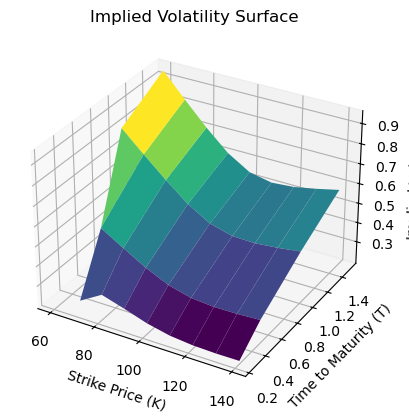

In [5]:
#Plot implied volatility without interpolation

K_grid, T_grid = np.meshgrid(K, T)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K_grid, T_grid, implied_vols.T, cmap='viridis')

ax.set_xlabel('Strike Price (K)')
ax.set_ylabel('Time to Maturity (T)')
ax.set_zlabel('Implied Volatility')
plt.title('Implied Volatility Surface')
plt.show()

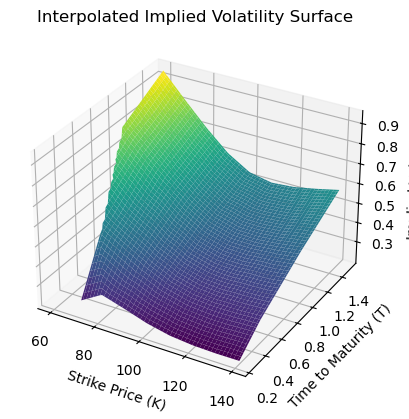

In [6]:
#Using Bilinear interpolation to interpolate all the strikes

from scipy.interpolate import griddata

S = 100
r = 0.03
K = np.array([60, 70, 80, 90, 100, 110, 120, 130, 140])
T = np.array([0.25, 0.5, 1, 1.5])
C = np.array([
    [40.2844, 42.4249, 50.8521, 59.1664],
    [30.5281, 33.5355, 42.6656, 51.2181],
    [21.0415, 24.9642, 34.4358, 42.9436],
    [12.2459, 16.9652, 26.4453, 34.7890],
    [5.2025, 10.1717, 19.4706, 27.8938],
    [1.3448, 5.4318, 14.4225, 23.3305],
    [0.2052, 2.7647, 11.2103, 20.7206],
    [0.0216, 1.4204, 9.1497, 19.1828],
    [0.0019, 0.7542, 7.7410, 18.1858]
])

implied_vols = np.array([[implied_volatility(C[i, j], S, K[i], T[j], r) for j in range(len(T))] for i in range(len(K))])

# Interpolation grid
K_interp = np.linspace(K.min(), K.max(), 100)
T_interp = np.linspace(T.min(), T.max(), 100)
K_grid, T_grid = np.meshgrid(K_interp, T_interp)

# Flatten the known grid points and their values for interpolation
points = np.array([[k, t] for k in K for t in T])
values = implied_vols.flatten()

# Interpolate
implied_vols_interp = griddata(points, values, (K_grid, T_grid), method='linear')

# Plot the interpolated surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K_grid, T_grid, implied_vols_interp, cmap='viridis')

ax.set_xlabel('Strike Price (K)')
ax.set_ylabel('Time to Maturity (T)')
ax.set_zlabel('Implied Volatility')
plt.title('Interpolated Implied Volatility Surface')
plt.show()